# To download tweets using twitter APi

In [1]:
"""import tweepy
import csv #Import csv
auth = tweepy.auth.OAuthHandler('xxxxxxxxx', 'xxxxxxxxxxxx')
auth.set_access_token('xxxxxxxxxx', 'xxxxxxxxxxxx')

api = tweepy.API(auth,wait_on_rate_limit=True)

# Open/create a file to append data to
csvFile = open('dataset.csv', 'a',encoding="utf-8",newline='')

#Use csv writer
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search,count=100000,
                           q = "Covid-19",re.sub('[^a-zA-Z]', '',clean )
                           tweet_mode='extended',
                           lang = "en").items():

    # Write a row to the CSV file. I use encode UTF-8
    csvWriter.writerow([tweet.full_text,tweet.user.screen_name,tweet.user.location])
    print(tweet.full_text,tweet.user.screen_name,tweet.user.location)
csvFile.close()"""

'import tweepy\nimport csv #Import csv\nauth = tweepy.auth.OAuthHandler(\'xxxxxxxxx\', \'xxxxxxxxxxxx\')\nauth.set_access_token(\'xxxxxxxxxx\', \'xxxxxxxxxxxx\')\n\napi = tweepy.API(auth,wait_on_rate_limit=True)\n\n# Open/create a file to append data to\ncsvFile = open(\'dataset.csv\', \'a\',encoding="utf-8",newline=\'\')\n\n#Use csv writer\ncsvWriter = csv.writer(csvFile)\n\nfor tweet in tweepy.Cursor(api.search,count=100000,\n                           q = "Covid-19",re.sub(\'[^a-zA-Z]\', \'\',clean )\n                           tweet_mode=\'extended\',\n                           lang = "en").items():\n\n    # Write a row to the CSV file. I use encode UTF-8\n    csvWriter.writerow([tweet.full_text,tweet.user.screen_name,tweet.user.location])\n    print(tweet.full_text,tweet.user.screen_name,tweet.user.location)\ncsvFile.close()'

# Importing dataset and Analysis

In [2]:
import pandas as pd
file_name='dataset.csv'
data = pd.read_csv(file_name, sep = ',',names = ['text','username','location'])
data.shape

(131563, 3)

In [3]:
data.head()

,text,username,location
0,RT @tsum_africa: In response to the current #C...,PaulABarter,Singapore
1,RT @FemAdesina: No presidential broadcast on C...,Abdulazizmento2,port Harcourt
2,Covid-19 Outbreak in Nigeria Is Just One of Af...,Ricardo_Gardel,"Tinton Falls, NJ"
3,RT @ChangeOrg_India: Walking miles without foo...,ahumanenough,NaN
4,RT @GhulamABilour: I have been tested positive...,tormakhay_s,"Sexi, Peru"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131563 entries, 0 to 131562
Data columns (total 3 columns):
text        131563 non-null object
username    131563 non-null object
location    92721 non-null object
dtypes: object(3)
memory usage: 3.0+ MB


In [5]:
data=data[(data['location'].notnull())]                      #dropping empty row
data = data.sample(frac=1).reset_index(drop=True)           #resetting index
data['len']=data["text"].str.len()                          #removing clipped tweets
df1= data[(data['len'] <=137)]
df2=data[(data['len'] >=150)]
data=pd.concat([df1,df2])                              
data = data.sample(frac=1).reset_index(drop=True)       #resetting index      

In [6]:
data.shape

(35482, 4)

In [7]:
data.head()

,text,username,location,len
0,RT @ExPressedSteel: Covid-19 Update 18/05/20 h...,ExPressedSteel,"Cowling, England",68
1,RT @jsolomonReports: Health Secretary says are...,AmericanRevere1,"Indiana, USA",136
2,RT @AFPgraphics: Children and COVID-19 @AFP in...,softpowers_,"Fortaleza, Ceará",79
3,Where is administration. Where is health care....,owaisgull13,"Anantnag, Jammu And Kashmir",173
4,Nicola Sturgeon voted 'most impressive politic...,pressgazette,"London, UK",122


# Cleaning data set by removing RT ,Links and @username

In [8]:
import numpy as np
import re
def remove_pattern(input_txt, pattern):                                           #function to remove pattern 
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(lst):
    lst = np.vectorize(remove_pattern)(lst, "\r")                                  
    lst = np.vectorize(remove_pattern)(lst, "\n")
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")                         # removing RT @x from tweets:
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")                             # removing  @xxx from tweets 
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")            # reremoving URL links http://xxx
    return lst

In [11]:
data['clean']= clean_tweets(data['text'])   #Cleaned Tweets are kept in separate coloumn

In [12]:
data.head()

,text,username,location,len,clean
0,RT @ExPressedSteel: Covid-19 Update 18/05/20 h...,ExPressedSteel,"Cowling, England",68,Covid-19 Update 18/05/20
1,RT @jsolomonReports: Health Secretary says are...,AmericanRevere1,"Indiana, USA",136,Health Secretary says areas reopening have no...
2,RT @AFPgraphics: Children and COVID-19 @AFP in...,softpowers_,"Fortaleza, Ceará",79,Children and COVID-19 infographic
3,Where is administration. Where is health care....,owaisgull13,"Anantnag, Jammu And Kashmir",173,Where is administration. Where is health care....
4,Nicola Sturgeon voted 'most impressive politic...,pressgazette,"London, UK",122,Nicola Sturgeon voted 'most impressive politic...


# Function to label tweets based on their sentiment.

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer           #vaderSentiment is used to tag tweets as positive, negative or neutral
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    if score['compound'] >= 0.05 :
        return 2
    elif (score['compound'] > -0.05) and (score['compound'] < 0.05) : 
        return 1 
    else :
        return 0

In [14]:
sentiments_using_vader = data.clean.apply(lambda text: sentiment_analyzer_scores(text))     #Each tweet goes throug vader function and gets labeled.
pd.DataFrame(sentiments_using_vader.value_counts())

,clean
2,15679
0,10346
1,9457


In [15]:
data['sentiment'] = sentiments_using_vader
data.head()

,text,username,location,len,clean,sentiment
0,RT @ExPressedSteel: Covid-19 Update 18/05/20 h...,ExPressedSteel,"Cowling, England",68,Covid-19 Update 18/05/20,1
1,RT @jsolomonReports: Health Secretary says are...,AmericanRevere1,"Indiana, USA",136,Health Secretary says areas reopening have no...,1
2,RT @AFPgraphics: Children and COVID-19 @AFP in...,softpowers_,"Fortaleza, Ceará",79,Children and COVID-19 infographic,1
3,Where is administration. Where is health care....,owaisgull13,"Anantnag, Jammu And Kashmir",173,Where is administration. Where is health care....,2
4,Nicola Sturgeon voted 'most impressive politic...,pressgazette,"London, UK",122,Nicola Sturgeon voted 'most impressive politic...,0


In [16]:
data.describe()

,len,sentiment
count,35482.000000,35482.000000
mean,162.006961,1.150302
std,77.083169,0.843149
min,8.000000,0.000000
25%,98.000000,0.000000
50%,129.000000,1.000000
75%,233.000000,2.000000
max,832.000000,2.000000


# Removing special characters, numbers, punctuations (except for #)

In [17]:
# remove special characters, numbers, punctuations (except for #)
data['clean'] = data['clean'].str.replace("[^a-zA-Z# ]", "")

# Removing stopwords ,converting into lower case and applying lematization.

In [19]:
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()
from nltk.corpus import stopwords
cleaned_tweets = []
for index, row in data.iterrows():            #This loop goes through every tweets and removes stopwords covnverts into lower case and applyes lematization
    words_without_stopwords = [wl.lemmatize(word.lower()) for word in row.clean.split() if not word in set(stopwords.words('english')) and '#' not in word.lower()]
    cleaned_tweets.append(' '.join(words_without_stopwords))
data['Fully_cleaned_tweets'] = cleaned_tweets
data.head(10)

,text,username,location,len,clean,sentiment,Fully_cleaned_tweets
0,RT @ExPressedSteel: Covid-19 Update 18/05/20 h...,ExPressedSteel,"Cowling, England",68,Covid Update,1,covid update
1,RT @jsolomonReports: Health Secretary says are...,AmericanRevere1,"Indiana, USA",136,Health Secretary says areas reopening have no...,1,health secretary say area reopening surge covi...
2,RT @AFPgraphics: Children and COVID-19 @AFP in...,softpowers_,"Fortaleza, Ceará",79,Children and COVID infographic,1,child covid infographic
3,Where is administration. Where is health care....,owaisgull13,"Anantnag, Jammu And Kashmir",173,Where is administration Where is health care W...,2,where administration where health care where h...
4,Nicola Sturgeon voted 'most impressive politic...,pressgazette,"London, UK",122,Nicola Sturgeon voted most impressive politici...,0,nicola sturgeon voted impressive politician co...
5,RT @TheEconomist: A Swedish epidemiologist rec...,hlawati55,"Glasgow, Scotland",124,A Swedish epidemiologist reckons that Stockho...,1,a swedish epidemiologist reckons stockholm rea...
6,RT @jilevin: COVID-19 Kills 20 times More Peop...,evilbluebird,"South Wales,UK",122,COVID Kills times More People per Week on Av...,0,covid kill time more people per week average f...
7,The Bank of England’s chief economist has indi...,thetimes,London,227,The Bank of Englands chief economist has indic...,0,the bank england chief economist indicated eme...
8,RT @realTuckFrumper: ‘Hang Fauci’ Sign Brandis...,SLReaves,Tanelorn 🏰,129,Hang Fauci Sign Brandished Amid Lockdown Prot...,1,hang fauci sign brandished amid lockdown prote...
9,"@Grund_gesetzt ""However, neither of the studie...",bckaemper,"Stuttgart, Germany",252,However neither of the studies attempted to e...,0,however neither study attempted establish peop...


# Bargraph of Sentiment

[Text(0, 0.5, '#Tweets'),
 Text(0.5, 0, 'Negative              Neutral               Positive'),
 Text(0.5, 1.0, 'Tweets of USA-corona')]

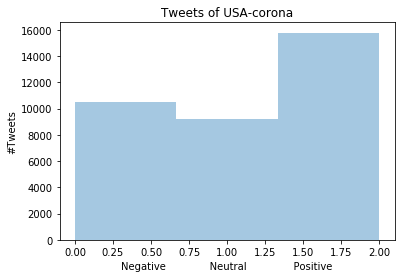

In [20]:
import seaborn as sns
sents =[]
for tw in data.Fully_cleaned_tweets:
    st = sentiment_analyzer_scores(tw)
    sents.append(st)
ax = sns.distplot(sents,kde=False,bins=3)
ax.set(xlabel='Negative              Neutral               Positive',ylabel='#Tweets',title="Tweets of USA-corona")


# Emotion of the tweets

In [21]:
from collections import Counter

def con(sentence):
    emotion_list = []
    sentence = sentence.split(' ')
    with open('emotions.txt','r') as file:
        for line in file:
            clear_line = line.replace("\n", '').replace(",",'').replace("'",'').strip()
            word, emotion = clear_line.split(':')

            if word in sentence:
                emotion_list.append(emotion)
        w = Counter(emotion_list)
        return w
    

In [22]:
data['emotion'] = data['Fully_cleaned_tweets'].apply(lambda x: con(x) )

In [23]:
data.head(10)

,text,username,location,len,clean,sentiment,Fully_cleaned_tweets,emotion
0,RT @ExPressedSteel: Covid-19 Update 18/05/20 h...,ExPressedSteel,"Cowling, England",68,Covid Update,1,covid update,{}
1,RT @jsolomonReports: Health Secretary says are...,AmericanRevere1,"Indiana, USA",136,Health Secretary says areas reopening have no...,1,health secretary say area reopening surge covi...,{}
2,RT @AFPgraphics: Children and COVID-19 @AFP in...,softpowers_,"Fortaleza, Ceará",79,Children and COVID infographic,1,child covid infographic,{}
3,Where is administration. Where is health care....,owaisgull13,"Anantnag, Jammu And Kashmir",173,Where is administration Where is health care W...,2,where administration where health care where h...,{}
4,Nicola Sturgeon voted 'most impressive politic...,pressgazette,"London, UK",122,Nicola Sturgeon voted most impressive politici...,0,nicola sturgeon voted impressive politician co...,{}
5,RT @TheEconomist: A Swedish epidemiologist rec...,hlawati55,"Glasgow, Scotland",124,A Swedish epidemiologist reckons that Stockho...,1,a swedish epidemiologist reckons stockholm rea...,{}
6,RT @jilevin: COVID-19 Kills 20 times More Peop...,evilbluebird,"South Wales,UK",122,COVID Kills times More People per Week on Av...,0,covid kill time more people per week average f...,{' average': 1}
7,The Bank of England’s chief economist has indi...,thetimes,London,227,The Bank of Englands chief economist has indic...,0,the bank england chief economist indicated eme...,{}
8,RT @realTuckFrumper: ‘Hang Fauci’ Sign Brandis...,SLReaves,Tanelorn 🏰,129,Hang Fauci Sign Brandished Amid Lockdown Prot...,1,hang fauci sign brandished amid lockdown prote...,{' happy': 1}
9,"@Grund_gesetzt ""However, neither of the studie...",bckaemper,"Stuttgart, Germany",252,However neither of the studies attempted to e...,0,however neither study attempted establish peop...,{}


In [24]:
emo=con(data['Fully_cleaned_tweets'].sum())

In [25]:
data['text'][8]

'RT @realTuckFrumper: ‘Hang Fauci’ Sign Brandished Amid Lockdown Protesters Trump Hailed As ‘Great People’ https://t.co/hj08vI0NRw'

# Plotting emotion bar graph

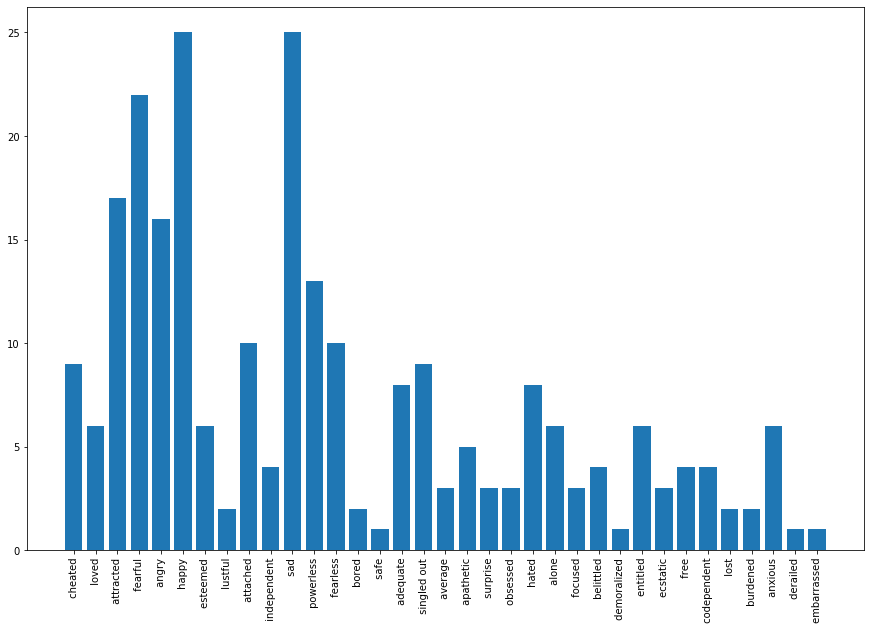

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.bar(emo.keys(),emo.values())
plt.xticks(rotation = 90)
plt.show()

# Wordcloud

In [27]:
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator
import urllib
import requests
import matplotlib.pyplot as plt
def generate_wordcloud(all_words):
    Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
    image_colors = ImageColorGenerator(Mask)
    wc = WordCloud(background_color='black', height=750, width=2000,mask=Mask).generate(all_words)
    plt.figure(figsize=(10,20))
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
    plt.axis('off')
    plt.show()

# Wordcloud for Positive Sentiment

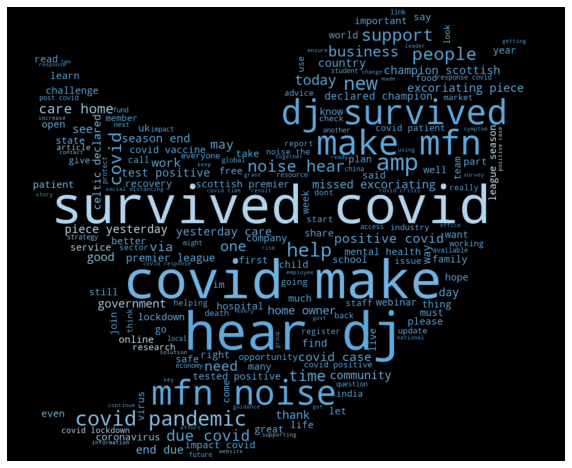

In [28]:
all_words = ' '.join([text for text in data['Fully_cleaned_tweets'][data.sentiment == 2]])
generate_wordcloud(all_words)

# Wordcloud for Neutral Sentiment

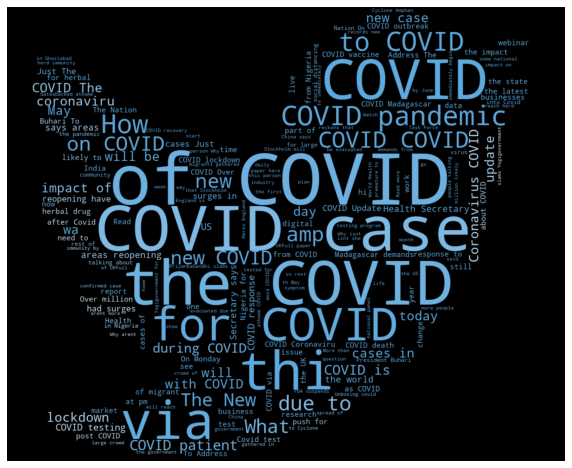

In [29]:
all_words = ' '.join([text for text in data['clean'][data.sentiment == 1]])
generate_wordcloud(all_words)

# Wordcloud for Negative Sentiment

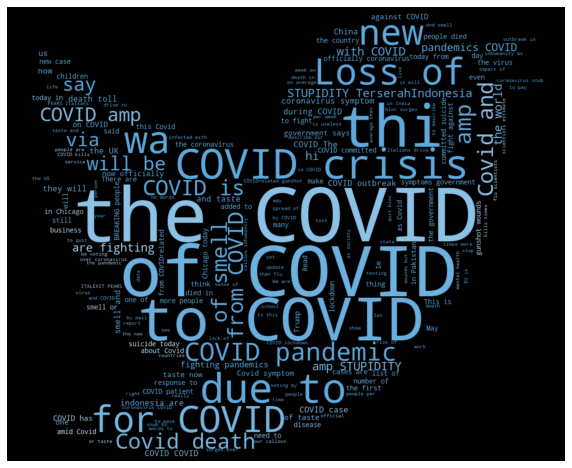

In [30]:
all_words = ' '.join([text for text in data['clean'][data.sentiment == 0]])
generate_wordcloud(all_words)

# Creating Hastag FreqDist

In [31]:
import nltk
                                                  #function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [32]:
hashtags = hashtag_extract(data['clean'])
hashtags = sum(hashtags, [])

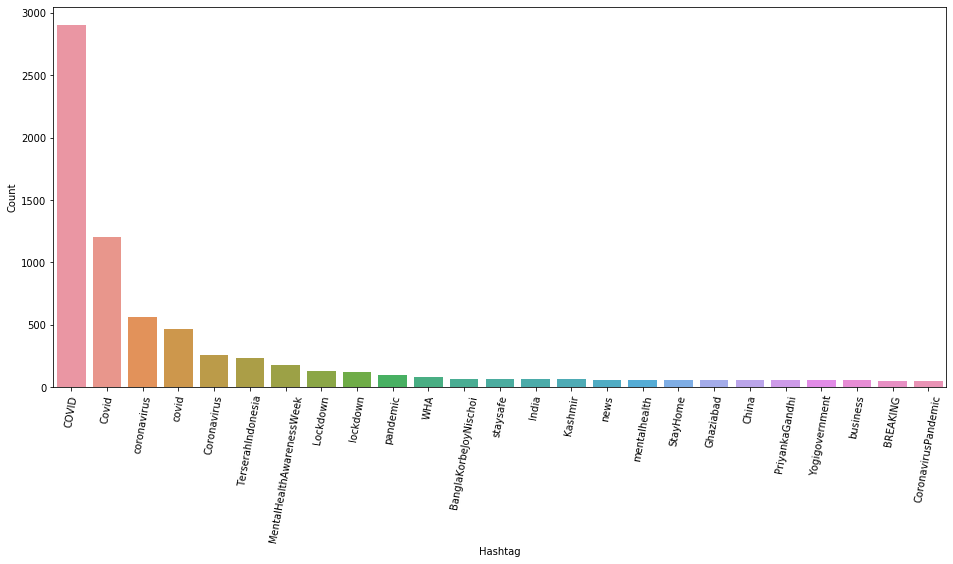

In [33]:
generate_hashtag_freqdist(hashtags)

# Tweets location bargraph

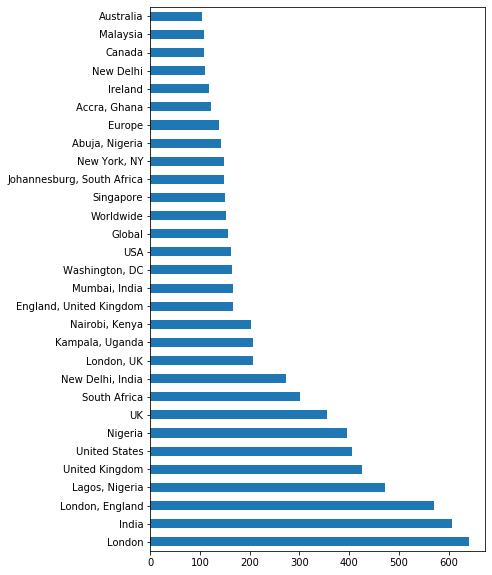

In [34]:
data['location'].value_counts().head(30).plot(kind='barh', figsize=(6,10))

# Extracting X and y from dataset

In [35]:
x = data.iloc[:,-2].values
y = data.iloc[:,-3].values

# Creating tfid vectorizer model

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
x = tfidf_word_vectorizer.fit_transform(x)

# Creating training and test data from the featureset and output label.

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#  Create and training a Machine Learning model.

In [38]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Validate the model created.

In [39]:
predictions = classifier.predict(X_test.toarray())

# Predicting sentiment of manual input

In [40]:
file_name='TestTweet.csv'
test=pd.read_csv(file_name)  

In [41]:
test['clean']=clean_tweets(test['text']) 
test['clean']=test['clean'].str.replace("[^a-zA-Z ]", " ")

In [42]:
for i,tweet in enumerate(test['clean']):
    op=classifier.predict(tfidf_word_vectorizer.transform([tweet]).toarray())
    if op == [0]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEGATIVE','\n')
    if op == [1]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEUTRAL','\n')
    if op == [2]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','POSITIVE','\n')

0 )  '  RT @djnicholl: Show us proof that Johnson is following science, MPs urge 

https://t.co/aN9ofVaQBV  '  
 = NEUTRAL 

1 )  '  Why people think 5G responsible for coronavirus https://t.co/jloVJuO0G0 via @YouTube  '  
 = NEUTRAL 

2 )  '  Yesterday I was walking along a pier of the #Amsterdam Oude Houthaven when an angry houseboat resident invited me leave as "they don't like walkers due to the #coronavirus" WTF...  '  
 = POSITIVE 

3 )  '  RT @WyeLea: The coronavirus crisis must not be allowed to delay Brexit https://t.co/4n6mip2MVg  '  
 = NEGATIVE 

4 )  '  #N4P #C4XD #IQAI 
Coronavirus: Moderna’s US vaccine first trials show immune response https://t.co/2vy25EMqEY  '  
 = NEUTRAL 

5 )  '  @HeshmatAlavi China knew what they were doing as soon as President Trump signed those papers. China will fulfill their deal as long as no pandemic happens. TWO days later &amp; here is Coronavirus knocking at our doors! Sue them, I say.  '  
 = NEGATIVE 

6 )  '  RT @jonworth: Even by Brexi

49 )  '  @WyeLea Agreed 100% Let's face it, we are already in a situation of a severe downturn due to the Coronavirus. The remainer argument about supply chains won't matter as we are already badly affected (for now). So we may as leave as things cannot get any worse, only much better.  '  
 = POSITIVE 

50 )  '  RT @EaterSouls: 72 people test positive for coronavirus after mass lockdown protest in Wisconsin https://t.co/CDzqAt6aAw  '  
 = POSITIVE 

51 )  '  Joining @SeneddCWLC is Nick Capaldi, Chief Executive @Arts_Wales_. Giving evidence on behalf of the sector, and discussing the support available for people and organisations working in the arts during the coronavirus crisis. https://t.co/YMPGpcgJWY  '  
 = NEGATIVE 

52 )  '  US #coronavirus death toll surpasses 90,000
#WamNews
https://t.co/O8RjoaMRyp https://t.co/5ykXRixOa8  '  
 = NEGATIVE 

53 )  '  RT @washingtonpost: Opinion: Trump is using the coronavirus as a cover to abuse his authority https://t.co/BM331nIelg  '  
 = NEGA

107 )  '  19 new confirmed cases of #COVID19 in the yet-to-be-named firm in Ibadan

Now, this is serious.

My Ibadan people, make una continue to stay safe

#coronavirus  '  
 = POSITIVE 

108 )  '  @MobilePunch This is what he has been preaching to his congregation. One of the member in my area that attends the church has been going around telling people about how 5G and not Coronavirus is responsible for what the world is currently battling at this point.  '  
 = POSITIVE 

109 )  '  https://t.co/DG3hrNNIXF - UK unemployment surges to 1.35 million – expert expects very quick rise to over 10%  '  
 = NEUTRAL 

110 )  '  @hezedgodson @RKRadhakrishn @kv_ramanan @ramyakannan yep, as if they had a telepathy with #coronavirus. d dumbo who said #TamilNadu wud be corona free in 3days n its d disease of d rich is d CM. we stand helpless. we’ve a great duty ahead, we cant simply sit n watch. we #millennials shd form a political movement aiming for CM chair  '  
 = POSITIVE 

111 )  '  RT @wash

177 )  '  Covid-19 Impact: Canada's Privacy Commissioners Outline Guidance For Governments And Developers Of... https://t.co/OVXG8RTipG  '  
 = NEUTRAL 

178 )  '  RT @fthealth: How coronavirus is exacerbating gaps in school provision https://t.co/2LswylNPJ9  '  
 = NEUTRAL 

179 )  '  For tips and ideas on how to look after your mental health click on the resource pack below: 

https://t.co/4yuoCgYwnC  '  
 = NEGATIVE 

180 )  '  @moreelen Time to sacrifice the shower curtain:
https://t.co/HRiyVXlOzc  '  
 = POSITIVE 

181 )  '  #LegendsCasino pushes back #reopening to #June7 https://t.co/s1Gz5dEC79 via @Yakima_Herald  '  
 = NEUTRAL 

182 )  '  Australia has reached a grim milestone; our 100th death from coronavirus. 93-year-old Alice Bacon passed away this morning at Sydney's Newmarch House. She is the 19th resident to die and her grieving family says it should not have happened. https://t.co/6iNboeyc4R #7NEWS https://t.co/HsdAQsoJbA  '  
 = NEGATIVE 

183 )  '  @Ilhan Imagine the d

221 )  '  Do not #self-diagnose . It gives you a false sense of #Security 
#coronavirus https://t.co/eroFAlJddY  '  
 = POSITIVE 

222 )  '  Wolves extend 33-year-old English goalkeeper John Ruddy's contract by a further year. (Birmingham Mail)

Watford's English striker Troy Deeney fear Premier League players will face a public backlash over mass testing for coronavirus. (Good Morning Britain via Evening Standard)  '  
 = POSITIVE 

223 )  '  Coronavirus is actually a gift to mankind, because it has gifted us God. It made us realize God. It has made us realize that there is a power beyond us. A power beyond human comprehension, that governs our destiny. This power is the devine power we call God. 
1/2  '  
 = POSITIVE 

224 )  '  RT @spectatorindex: JUST IN: Worldwide coronavirus death toll reaches 320,000  '  
 = NEGATIVE 

225 )  '  RT @Bijan63: Brilliant cartoon:
#Trump gets tested. 
There's nothing there.  
#Coronavirus https://t.co/c6iUjz6EL0  '  
 = NEUTRAL 

226 )  '  @JamesMel

In [43]:
tweet="@briantylercohen Hey #Insane @realDonaldTrump ! Are you crazy? ANY of them don't need to die at all."
clean=clean_tweets(tweet)
clean=str(clean)
clean=re.sub('[^a-zA-Z]', ' ',clean )
clean=[clean]
op=classifier.predict(tfidf_word_vectorizer.transform(clean).toarray())
if op == [0]:
    print(tweet,'\n','=','NEGATIVE','\n')
if op == [1]:
    print(tweet,'\n','=','NEUTRAL','\n')
if op == [2]:
    print(tweet,'\n','=','POSITIVE','\n')

@briantylercohen Hey #Insane @realDonaldTrump ! Are you crazy? ANY of them don't need to die at all. 
 = NEGATIVE 



# Evaluate the model

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy score : ',accuracy_score(y_test, predictions)*100,'\n')

Accuracy score :  81.78103423981963 



In [45]:
print(confusion_matrix(y_test,predictions),'\n')

[[1553  220  295]
 [ 107 1628  151]
 [ 211  309 2623]] 



In [46]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      2068
           1       0.75      0.86      0.81      1886
           2       0.85      0.83      0.84      3143

    accuracy                           0.82      7097
   macro avg       0.81      0.82      0.81      7097
weighted avg       0.82      0.82      0.82      7097

